In [1]:
import torch
from torch import nn
from utils.training import train_accuracy
import matplotlib.pyplot as plt
from os import listdir
from tqdm import tqdm, trange

import numpy as np
from utils.pruning import get_prune_percentage, prune_model, number_of_parameters
from models.resnet_real import ResNet101, ResNet152
from models.resnet_quat import ResNet101_quat, ResNet152_quat
from oth import *
import json
import torch.multiprocessing as mp
from data_loaders.imagenet import Train, Val

GPU = torch.device("cuda:1")
base_dir = "saved_models"
ext = "pdf"

In [2]:
models = ["RN18_real", "RN18_quat", "RN34_real", "RN34_quat", "RN50_real", "RN50_quat", "RN101_real", "RN101_quat", "RN152_real", "RN152_quat"]
for name in models:
    a = torch.load(f'saved_models/{name}_prune/{name}_unpruned.pt')
    print(f"{name}:\t{number_of_parameters(a)/1e6:.2f}M")

RN18_real:	11.68M
RN18_quat:	2.93M
RN34_real:	21.79M
RN34_quat:	5.46M
RN50_real:	25.55M
RN50_quat:	6.43M
RN101_real:	44.54M
RN101_quat:	11.22M
RN152_real:	60.19M
RN152_quat:	15.16M


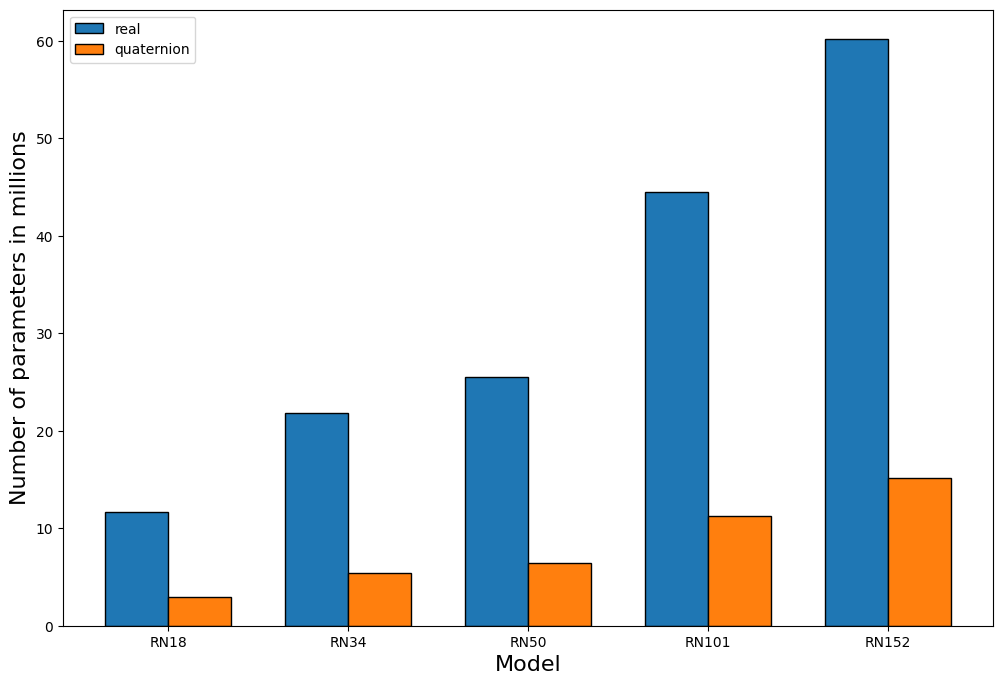

In [21]:
barWidth = 0.35
fig = plt.subplots(figsize =(12, 8))

# RN18_real:	11.68M
# RN18_quat:	2.93M
# RN34_real:	21.79M
# RN34_quat:	5.46M
# RN50_real:	25.55M
# RN50_quat:	6.43M
# RN101_real:	44.54M
# RN101_quat:	11.22M
# RN152_real:	60.19M
# RN152_quat:	15.16M


# set height of bar
real = [11.68, 21.79, 25.55, 44.54, 60.19]
quat = [2.93, 5.46, 6.43, 11.22, 15.16]
 
# Set position of bar on X axis
br1 = np.arange(5)
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, real, color ='tab:blue', width = barWidth, edgecolor ='black', label ='real')
plt.bar(br2, quat, color ='tab:orange', width = barWidth, edgecolor ='black', label ='quaternion')
 
# Adding Xticks
plt.xlabel('Model', fontsize=16)
plt.ylabel('Number of parameters in millions', fontsize=16)
plt.xticks([r + 0.5*barWidth for r in range(len(real))], ["RN18", "RN34", "RN50", "RN101", "RN152"])
 
plt.legend()
plt.savefig(f"saved_models/number_of_parameters.{ext}", bbox_inches='tight')

In [3]:
def rule(x):
    a = x[:-3].split("_")[-1]
    try: return int(a)
    except: return 0

def proc(num, n = 2):
    if isinstance(num, int): return num
    else:
        if int(num) == num: return int(num)
        else: return round(num, n)

model_groups = {
    18:  ["RN18_real", "RN18_quat"],
    34:  ["RN34_real", "RN34_quat"],
    50:  ["RN50_real", "RN50_quat"],
    101: ["RN101_real", "RN101_quat"],
    152: ["RN152_real", "RN152_quat"]
}
unif = {}

In [4]:
validation_generator = torch.utils.data.DataLoader(Val(), batch_size=256, shuffle=False)

## ResNet 18

In [5]:
load = True
models = model_groups[18]
if load:
    with open("saved_models/RN18.json") as f:
        models = json.load(f)
else:
    model_paths = {}

    # finding the saved models
    for model in models:
        path = f"{base_dir}/{model}_prune"
        model_paths[model] = {k:{"accuracy":None, "prune_perc": None} for k in sorted(map(lambda x: f"{path}/{x}", listdir(path)), key = rule)}
    models =  model_paths

    # evaluating the saved models
    for model_type in models:
        for model_path in tqdm(models[model_type], desc = model_type, unit = "model"):
            model = torch.load(model_path).to(GPU)
            models[model_type][model_path]["prune_perc"] = get_prune_percentage(model)
            models[model_type][model_path]["accuracy"] = train_accuracy(model, validation_generator, GPU)

    with open("saved_models/RN18.json", "w") as f:
        json.dump(models, f)

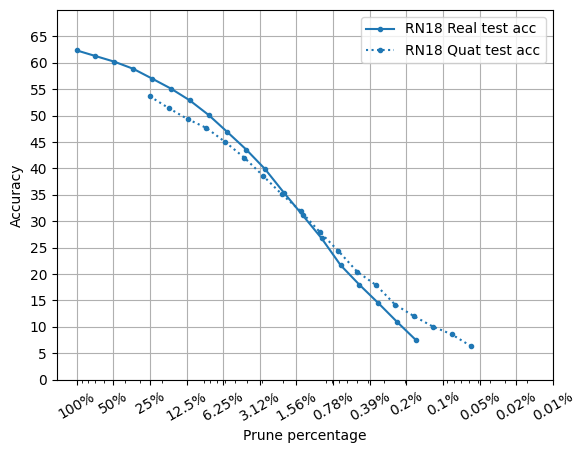

In [6]:
# RN18_real:  11.68M
# RN18_quat:  2.93M

real_prune_percs = []
real_test_accs = []
real_num_params = []
for m in models["RN18_real"].values():
    real_prune_percs.append(m["prune_perc"]*100)
    real_num_params.append(m["prune_perc"]*11.68)
    real_test_accs.append(m["accuracy"])

quat_prune_percs = []
quat_test_accs = []
quat_num_params = []
for m in models["RN18_quat"].values():
    quat_prune_percs.append(m["prune_perc"]*25)
    quat_num_params.append(m["prune_perc"]*2.93)
    quat_test_accs.append(m["accuracy"])

unif["R18_acc"] = real_test_accs
unif["R18_prune"] = real_prune_percs
unif["R18_params"] = real_num_params
unif["Q18_acc"] = quat_test_accs
unif["Q18_prune"] = quat_prune_percs
unif["Q18_params"] = quat_num_params

plt.plot(real_prune_percs, real_test_accs, linestyle="-", marker=".", color="tab:blue", label="RN18 Real test acc")
plt.plot(quat_prune_percs, quat_test_accs, linestyle=":", marker=".", color="tab:blue", label="RN18 Quat test acc")


plt.xscale("log")
plt.legend()
plt.xlabel("Prune percentage")
plt.ylabel("Accuracy")
plt.gca().invert_xaxis()
ticks = [100*0.5**i for i in range(14)]
plt.xticks(ticks, [f"{proc(t)}%" for t in ticks], rotation=30)
plt.yticks(range(0, 70, 5))
plt.ylim(0, 70)
plt.grid()
plt.savefig(f"saved_models/RN18.{ext}", bbox_inches='tight')

## ResNet 34

In [7]:
load = True
models = model_groups[34]
if load:
    with open("saved_models/RN34.json") as f:
        models = json.load(f)
else:
    model_paths = {}

    # finding the saved models
    for model in models:
        path = f"{base_dir}/{model}_prune"
        model_paths[model] = {k:{"accuracy":None, "prune_perc": None} for k in sorted(map(lambda x: f"{path}/{x}", listdir(path)), key = rule)}
    models =  model_paths

    # evaluating the saved models
    for model_type in models:
        for model_path in tqdm(models[model_type], desc = model_type, unit = "model"):
            model = torch.load(model_path).to(GPU)
            models[model_type][model_path]["prune_perc"] = get_prune_percentage(model)
            models[model_type][model_path]["accuracy"] = train_accuracy(model, validation_generator, GPU)

    with open("saved_models/RN34.json", "w") as f:
        json.dump(models, f)

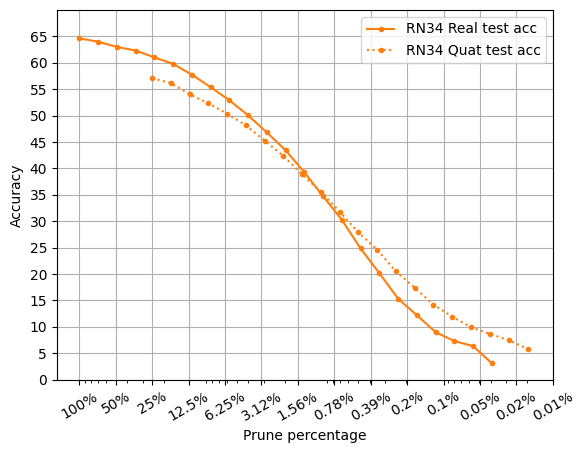

In [8]:
# RN34_real:  21.79M
# RN34_quat:  5.46M

real_prune_percs = []
real_num_params = []
real_test_accs = []
for m in models["RN34_real"].values():
    real_prune_percs.append(m["prune_perc"]*100)
    real_num_params.append(m["prune_perc"]*21.79)
    real_test_accs.append(m["accuracy"])

quat_prune_percs = []
quat_test_accs = []
quat_num_params = []
for m in models["RN34_quat"].values():
    quat_prune_percs.append(m["prune_perc"]*25)
    quat_num_params.append(m["prune_perc"]*5.46)
    quat_test_accs.append(m["accuracy"])

unif["R34_acc"] = real_test_accs
unif["R34_prune"] = real_prune_percs
unif["R34_params"] = real_num_params
unif["Q34_acc"] = quat_test_accs
unif["Q34_prune"] = quat_prune_percs
unif["Q34_params"] = quat_num_params

plt.plot(real_prune_percs, real_test_accs, linestyle="-", marker=".", color="tab:orange", label="RN34 Real test acc")
plt.plot(quat_prune_percs, quat_test_accs, linestyle=":", marker=".", color="tab:orange", label="RN34 Quat test acc")


plt.xscale("log")
plt.legend()
plt.xlabel("Prune percentage")
plt.ylabel("Accuracy")
plt.gca().invert_xaxis()
ticks = [100*0.5**i for i in range(14)]
plt.xticks(ticks, [f"{proc(t)}%" for t in ticks], rotation=30)
plt.yticks(range(0, 70, 5))
plt.ylim(0, 70)
plt.grid()
plt.savefig(f"saved_models/RN34.{ext}", bbox_inches='tight')

## ResNet 50

In [9]:
load = True
models = model_groups[50]

if load:
    with open("saved_models/RN50.json") as f:
        models = json.load(f)
else:
    model_paths = {}

    # finding the saved models
    for model in models:
        path = f"{base_dir}/{model}_prune"
        model_paths[model] = {k:{"accuracy":None, "prune_perc": None} for k in sorted(map(lambda x: f"{path}/{x}", listdir(path)), key = rule)}
    models =  model_paths

    # evaluating the saved models
    for model_type in models:
        for model_path in tqdm(models[model_type], desc = model_type, unit = "model"):
            model = torch.load(model_path).to(GPU)
            models[model_type][model_path]["prune_perc"] = get_prune_percentage(model)
            models[model_type][model_path]["accuracy"] = train_accuracy(model, validation_generator, GPU)

    with open("saved_models/RN50.json", "w") as f:
        json.dump(models, f) 

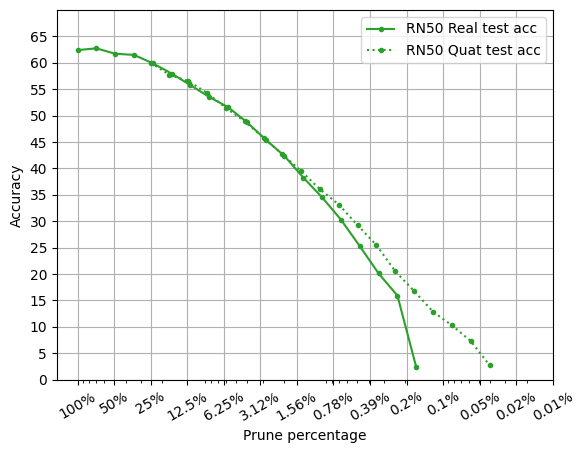

In [10]:
real_prune_percs = []
real_test_accs = []
real_num_params = []
for m in models["RN50_real"].values():
    real_prune_percs.append(m["prune_perc"]*100)
    real_num_params.append(m["prune_perc"]*25.55)
    real_test_accs.append(m["accuracy"])

quat_prune_percs = []
quat_test_accs = []
quat_num_params = []
for m in models["RN50_quat"].values():
    quat_prune_percs.append(m["prune_perc"]*25)
    quat_num_params.append(m["prune_perc"]*6.43)
    quat_test_accs.append(m["accuracy"])

unif["R50_acc"] = real_test_accs
unif["R50_prune"] = real_prune_percs
unif["R50_params"] = real_num_params
unif["Q50_acc"] = quat_test_accs
unif["Q50_prune"] = quat_prune_percs
unif["Q50_params"] = quat_num_params

plt.plot(real_prune_percs, real_test_accs, linestyle="-", marker=".", color="tab:green", label="RN50 Real test acc")
plt.plot(quat_prune_percs, quat_test_accs, linestyle=":", marker=".", color="tab:green", label="RN50 Quat test acc")


plt.xscale("log")
plt.legend()
plt.xlabel("Prune percentage")
plt.ylabel("Accuracy")
plt.gca().invert_xaxis()
ticks = [100*0.5**i for i in range(14)]
plt.xticks(ticks, [f"{proc(t)}%" for t in ticks], rotation=30)
plt.yticks(range(0, 70, 5))
plt.ylim(0, 70)
plt.grid()
plt.savefig(f"saved_models/RN50.{ext}", bbox_inches='tight')

## ResNet 101

In [11]:
load = True
models = model_groups[101]
# /home/aritra/project/quatLT23/precious_saved_models
if load:
    with open("saved_models/RN101.json") as f:
        models = json.load(f)
else:
    model_paths = {}

    # finding the saved models
    for model in models:
        path = f"saved_models/{model}_prune"
        model_paths[model] = {k:{"accuracy":None, "prune_perc": None} for k in sorted(map(lambda x: f"{path}/{x}", listdir(path)), key = rule)}
    models =  model_paths

    # evaluating the saved models
    for model_type in models:
        for model_path in tqdm(models[model_type], desc = model_type, unit = "model"):
            model = torch.load(model_path).to(GPU)
            models[model_type][model_path]["prune_perc"] = get_prune_percentage(model)
            models[model_type][model_path]["accuracy"] = train_accuracy(model, validation_generator, GPU)

    with open("saved_models/RN101.json", "w") as f:
        json.dump(models, f)

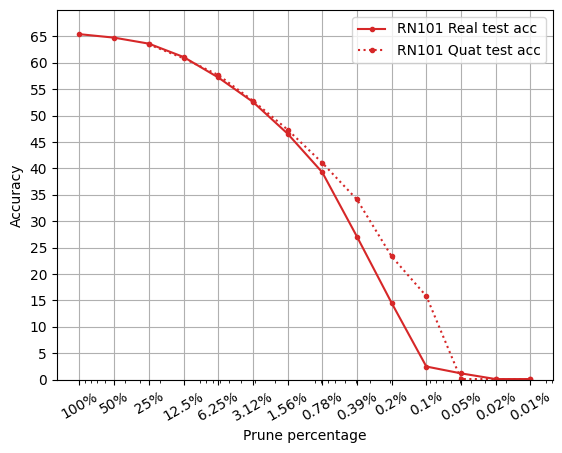

In [12]:
# RN101_real: 44.54M
# RN101_quat: 11.22M

real_prune_percs = []
real_test_accs = []
real_num_params = []
for m in models["RN101_real"].values():
    real_prune_percs.append(m["prune_perc"]*100)
    real_num_params.append(m["prune_perc"]*44.54)
    real_test_accs.append(m["accuracy"])

quat_prune_percs = []
quat_test_accs = []
quat_num_params = []
for m in models["RN101_quat"].values():
    quat_prune_percs.append(m["prune_perc"]*25)
    quat_num_params.append(m["prune_perc"]*11.22)
    quat_test_accs.append(m["accuracy"])

unif["R101_acc"] = real_test_accs
unif["R101_prune"] = real_prune_percs
unif["R101_params"] = real_num_params
unif["Q101_acc"] = quat_test_accs
unif["Q101_prune"] = quat_prune_percs
unif["Q101_params"] = quat_num_params

plt.plot(real_prune_percs, real_test_accs, linestyle="-", marker=".", color="tab:red", label="RN101 Real test acc")
plt.plot(quat_prune_percs, quat_test_accs, linestyle=":", marker=".", color="tab:red", label="RN101 Quat test acc")


plt.xscale("log")
plt.legend()
plt.xlabel("Prune percentage")
plt.ylabel("Accuracy")
plt.gca().invert_xaxis()
ticks = [100*0.5**i for i in range(14)]
plt.xticks(ticks, [f"{proc(t)}%" for t in ticks], rotation=30)
plt.yticks(range(0, 70, 5))
plt.ylim(0, 70)
plt.grid()
plt.savefig(f"saved_models/RN101.{ext}", bbox_inches='tight')

## ResNet 152

In [13]:
load = True
models = model_groups[152]
# /home/aritra/project/quatLT23/precious_saved_models
if load:
    with open("saved_models/RN152.json") as f:
        models = json.load(f)
else:
    model_paths = {}

    # finding the saved models
    for model in models:
        path = f"saved_models/{model}_prune"
        model_paths[model] = {k:{"accuracy":None, "prune_perc": None} for k in sorted(map(lambda x: f"{path}/{x}", listdir(path)), key = rule)}
    models =  model_paths

    # evaluating the saved models
    for model_type in models:
        for model_path in tqdm(models[model_type], desc = model_type, unit = "model"):
            model = torch.load(model_path).to(GPU)
            models[model_type][model_path]["prune_perc"] = get_prune_percentage(model)
            models[model_type][model_path]["accuracy"] = train_accuracy(model, validation_generator, GPU)

    with open("saved_models/RN152.json", "w") as f:
        json.dump(models, f)

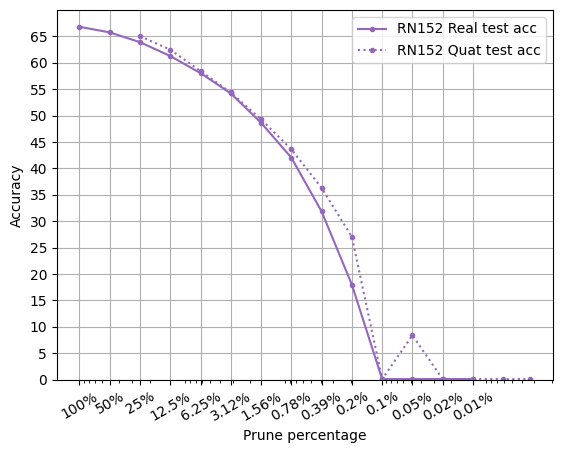

In [14]:
# RN152_real:  60.19M
# RN152_quat:  15.16M

real_prune_percs = []
real_test_accs = []
real_num_params = []
for m in models["RN152_real"].values():
    real_prune_percs.append(m["prune_perc"]*100)
    real_num_params.append(m["prune_perc"]*60.19)
    real_test_accs.append(m["accuracy"])

quat_prune_percs = []
quat_test_accs = []
quat_num_params = []
for m in models["RN152_quat"].values():
    quat_prune_percs.append(m["prune_perc"]*25)
    quat_num_params.append(m["prune_perc"]*15.16)
    quat_test_accs.append(m["accuracy"])

unif["R152_acc"] = real_test_accs
unif["R152_prune"] = real_prune_percs
unif["R152_params"] = real_num_params
unif["Q152_acc"] = quat_test_accs
unif["Q152_prune"] = quat_prune_percs
unif["Q152_params"] = quat_num_params

plt.plot(real_prune_percs, real_test_accs, linestyle="-", marker=".", color="tab:purple", label="RN152 Real test acc")
plt.plot(quat_prune_percs, quat_test_accs, linestyle=":", marker=".", color="tab:purple", label="RN152 Quat test acc")


plt.xscale("log")
plt.legend()
plt.xlabel("Prune percentage")
plt.ylabel("Accuracy")
plt.gca().invert_xaxis()
ticks = [100*0.5**i for i in range(14)]
plt.xticks(ticks, [f"{proc(t)}%" for t in ticks], rotation=30)
plt.yticks(range(0, 70, 5))
plt.ylim(0, 70)
plt.grid()
plt.savefig(f"saved_models/RN152.{ext}", bbox_inches='tight')

# Number of parameters

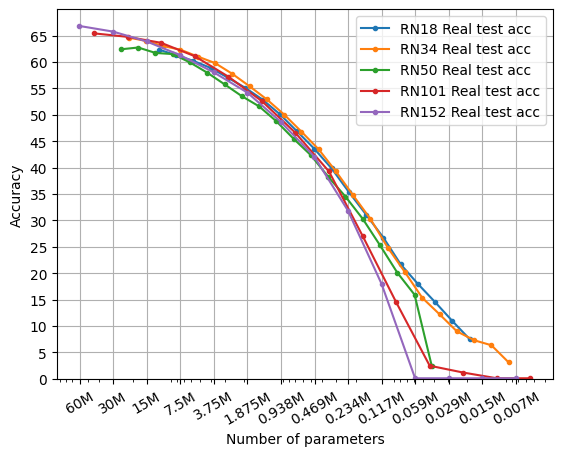

In [15]:
plt.plot(unif["R18_params"], unif["R18_acc"], linestyle="-", marker=".", color="tab:blue", label="RN18 Real test acc")
plt.plot(unif["R34_params"], unif["R34_acc"], linestyle="-", marker=".", color="tab:orange", label="RN34 Real test acc")
plt.plot(unif["R50_params"], unif["R50_acc"], linestyle="-", marker=".", color="tab:green", label="RN50 Real test acc")
plt.plot(unif["R101_params"], unif["R101_acc"], linestyle="-", marker=".", color="tab:red", label="RN101 Real test acc")
plt.plot(unif["R152_params"], unif["R152_acc"], linestyle="-", marker=".", color="tab:purple", label="RN152 Real test acc")

plt.xscale("log")
plt.legend()
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy")
plt.gca().invert_xaxis()
ticks2 = [60*0.5**i for i in range(14)]
plt.xticks(ticks2, [f"{proc(t, 3)}M" for t in ticks2], rotation=30)
plt.yticks(range(0, 70, 5))
plt.ylim(0, 70)
plt.grid()
plt.savefig(f"saved_models/#params_real.{ext}", bbox_inches="tight")

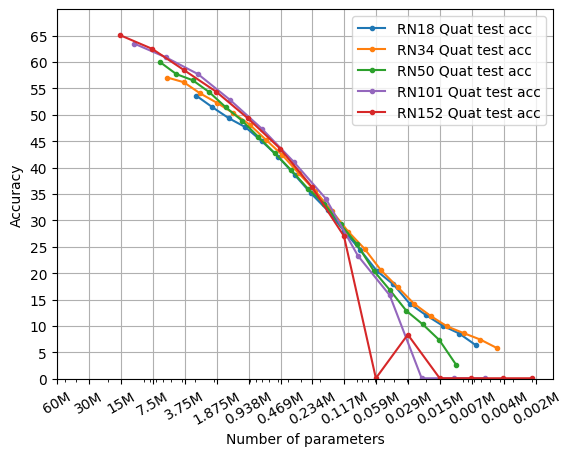

In [19]:
plt.plot(unif["Q18_params"], unif["Q18_acc"], linestyle="-", marker=".", color="tab:blue", label="RN18 Quat test acc")
plt.plot(unif["Q34_params"], unif["Q34_acc"], linestyle="-", marker=".", color="tab:orange", label="RN34 Quat test acc")
plt.plot(unif["Q50_params"], unif["Q50_acc"], linestyle="-", marker=".", color="tab:green", label="RN50 Quat test acc")
plt.plot(unif["Q101_params"], unif["Q101_acc"], linestyle="-", marker=".", color="tab:purple", label="RN101 Quat test acc")
plt.plot(unif["Q152_params"], unif["Q152_acc"], linestyle="-", marker=".", color="tab:red", label="RN152 Quat test acc")

plt.xscale("log")
plt.legend()
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy")
plt.gca().invert_xaxis()
ticks2 = [60*0.5**i for i in range(16)]
plt.xticks(ticks2, [f"{proc(t, 3)}M" for t in ticks2], rotation=30)
plt.yticks(range(0, 70, 5))
plt.ylim(0, 70)
plt.grid()
plt.savefig(f"saved_models/#params_quat.{ext}", bbox_inches="tight")

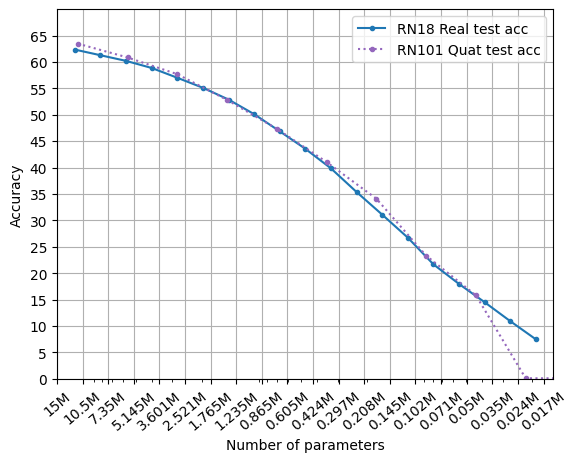

In [31]:
plt.plot(unif["R18_params"], unif["R18_acc"], linestyle="-", marker=".", color="tab:blue", label="RN18 Real test acc")
plt.plot(unif["Q101_params"], unif["Q101_acc"], linestyle=":", marker=".", color="tab:purple", label="RN101 Quat test acc")

plt.xscale("log")
plt.legend()
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy")
plt.gca().invert_xaxis()
ticks2 = [15*0.7**i for i in range(20)]
plt.xticks(ticks2, [f"{proc(t, 3)}M" for t in ticks2], rotation=40)
plt.yticks(range(0, 70, 5))
plt.ylim(0, 70)
plt.xlim(15, 0.015)
plt.grid()
plt.savefig(f"saved_models/#params_quat.{ext}", bbox_inches="tight")

In [17]:
# https://arxiv.org/pdf/2301.04623.pdf
# https://openreview.net/pdf?id=K398CuAKVKB